In [240]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

# for visualizing locations on maps
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
from cartopy.io import shapereader
import geopandas
import shapely

# predicting
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso
from sklearn.svm import SVR

## Load and match the data

In [241]:
# Load the datasets
weather_path = "../opsd-weather_data-2019-04-09/weather_data.csv"
wdf = pd.read_csv(weather_path)

ts_path = "../opsd-time_series-2019-06-05/time_series_60min_singleindex.csv"
edf = pd.read_csv(ts_path)

In [242]:
# Look for matching timestamps
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

timestamps = intersection(list(edf.utc_timestamp), list(wdf.utc_timestamp))

# Filter for only those timestamps
edf = edf[edf.utc_timestamp.isin(timestamps)]
wdf = wdf[wdf.utc_timestamp.isin(timestamps)]
edf = edf.sort_values(by='utc_timestamp')
wdf = wdf.sort_values(by='utc_timestamp')

# Only keep recent data from 2016
edf = edf.loc[edf.utc_timestamp.str.startswith("2016")]
wdf = wdf.loc[wdf.utc_timestamp.str.startswith('2016')]


In [243]:
edf.index = edf.utc_timestamp
wdf.index = wdf.utc_timestamp

In [244]:
# Get German values
wdf = wdf.filter(regex='DE_*', axis=1)
edf = edf.filter(regex='DE_*', axis=1)

In [245]:
# Remove any dates where we have NaNs in the data
keep_cols = ['DE_wind_onshore_generation_actual', 'DE_wind_offshore_generation_actual', 'DE_solar_generation_actual']
edf = edf[keep_cols]

keep_rows = edf.isnull().any(axis=1)
keep_rows = [not x for x in keep_rows]

edf = edf.loc[keep_rows]
wdf = wdf.loc[keep_rows]

In [246]:
edf.head()

,DE_wind_onshore_generation_actual,DE_wind_offshore_generation_actual,DE_solar_generation_actual
utc_timestamp,,,
2016-01-01T00:00:00Z,6294.0,2286.0,0.0
2016-01-01T01:00:00Z,6314.0,2229.0,0.0
2016-01-01T02:00:00Z,6431.0,2012.0,0.0
2016-01-01T03:00:00Z,6352.0,1943.0,0.0
2016-01-01T04:00:00Z,5736.0,1582.0,0.0


In [247]:
wdf.head()

,DE_windspeed_10m,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal,DE11_windspeed_10m,DE11_temperature,DE11_radiation_direct_horizontal,DE11_radiation_diffuse_horizontal,DE12_windspeed_10m,DE12_temperature,...,DEE0_radiation_direct_horizontal,DEE0_radiation_diffuse_horizontal,DEF0_windspeed_10m,DEF0_temperature,DEF0_radiation_direct_horizontal,DEF0_radiation_diffuse_horizontal,DEG0_windspeed_10m,DEG0_temperature,DEG0_radiation_direct_horizontal,DEG0_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01T00:00:00Z,3.3849,2.064,0.0,0.0,1.73,2.05,0.0,0.0,2.45,2.03,...,0.0,0.0,4.66,3.16,0.0,0.0,3.22,0.21,0.0,0.0
2016-01-01T01:00:00Z,3.3636,1.965,0.0,0.0,1.73,1.84,0.0,0.0,2.50,1.90,...,0.0,0.0,4.39,2.95,0.0,0.0,3.22,0.23,0.0,0.0
2016-01-01T02:00:00Z,3.3268,1.887,0.0,0.0,1.74,1.72,0.0,0.0,2.49,1.84,...,0.0,0.0,4.12,2.82,0.0,0.0,3.36,0.27,0.0,0.0
2016-01-01T03:00:00Z,3.2796,1.885,0.0,0.0,1.73,1.82,0.0,0.0,2.38,2.01,...,0.0,0.0,4.06,2.78,0.0,0.0,3.46,0.30,0.0,0.0
2016-01-01T04:00:00Z,3.1705,1.866,0.0,0.0,1.77,1.95,0.0,0.0,2.33,2.16,...,0.0,0.0,4.18,2.80,0.0,0.0,3.47,0.24,0.0,0.0


## Exploratory plotting

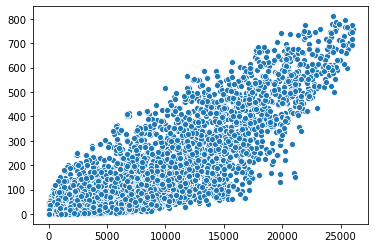

In [248]:
# Solar
sns.scatterplot(np.array(edf.DE_solar_generation_actual), np.array(wdf.DE_radiation_direct_horizontal))

In [249]:
np.corrcoef(np.array(edf.DE_solar_generation_actual), np.array(wdf.DE_radiation_direct_horizontal))

array([[1.        , 0.89268589],
       [0.89268589, 1.        ]])

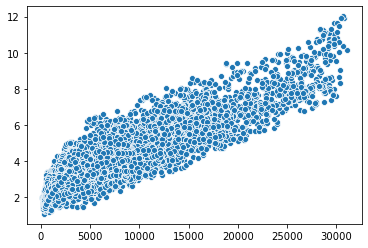

In [250]:
# Wind
sns.scatterplot(np.array(edf.DE_wind_onshore_generation_actual), np.array(wdf.DE_windspeed_10m))

In [251]:
np.corrcoef(np.array(edf.DE_wind_onshore_generation_actual), np.array(wdf.DE_windspeed_10m))

array([[1.        , 0.87639831],
       [0.87639831, 1.        ]])

# Wind prediction model

In [252]:
wind_x = wdf.copy()
wind_y = np.array(edf.copy().DE_wind_onshore_generation_actual)

wind_x = np.array(wind_x.filter(regex='windspeed_10m'))


In [254]:
model = LinearRegression()

model = model.fit(wind_x, wind_y)
model.score(wind_x, wind_y)

0.868822194136297

In [257]:
wind_x = wdf.copy()
wind_x.filter(regex='windspeed_10m')

,DE_windspeed_10m,DE11_windspeed_10m,DE12_windspeed_10m,DE13_windspeed_10m,DE14_windspeed_10m,DE21_windspeed_10m,DE22_windspeed_10m,DE23_windspeed_10m,DE24_windspeed_10m,DE25_windspeed_10m,...,DEB1_windspeed_10m,DEB2_windspeed_10m,DEB3_windspeed_10m,DEC0_windspeed_10m,DED2_windspeed_10m,DED4_windspeed_10m,DED5_windspeed_10m,DEE0_windspeed_10m,DEF0_windspeed_10m,DEG0_windspeed_10m
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01T00:00:00Z,3.3849,1.73,2.45,1.57,1.14,1.06,1.34,1.23,1.65,1.16,...,3.53,3.61,2.23,3.08,3.62,3.57,4.41,4.26,4.66,3.22
2016-01-01T01:00:00Z,3.3636,1.73,2.50,1.60,1.14,0.89,1.33,1.02,1.62,1.04,...,3.33,3.29,2.20,2.74,3.91,3.36,4.11,4.05,4.39,3.22
2016-01-01T02:00:00Z,3.3268,1.74,2.49,1.52,1.26,0.79,1.27,0.90,1.74,1.12,...,3.24,3.09,2.18,2.46,3.93,3.22,4.05,4.00,4.12,3.36
2016-01-01T03:00:00Z,3.2796,1.73,2.38,1.45,1.36,0.70,1.13,0.86,1.88,1.36,...,3.23,3.09,2.14,2.38,3.87,3.29,4.13,3.91,4.06,3.46
2016-01-01T04:00:00Z,3.1705,1.77,2.33,1.37,1.39,0.61,0.92,1.00,2.07,1.60,...,3.21,3.17,2.19,2.46,3.86,3.43,4.03,3.78,4.18,3.47
2016-01-01T05:00:00Z,3.0251,1.81,2.31,1.24,1.42,0.70,0.78,1.25,2.19,1.72,...,3.01,3.12,2.27,2.51,3.94,3.55,3.89,3.71,4.27,3.42
2016-01-01T06:00:00Z,2.8701,1.92,2.22,1.13,1.37,1.07,0.94,1.47,2.20,1.81,...,2.81,2.98,2.28,2.46,3.97,3.66,3.91,3.68,4.24,3.30
2016-01-01T07:00:00Z,2.6828,1.85,2.06,1.03,1.16,1.27,1.24,1.65,2.20,1.87,...,2.53,2.78,2.17,2.30,4.03,3.86,3.91,3.48,4.05,3.07
2016-01-01T08:00:00Z,2.6454,1.87,2.02,1.05,0.99,1.29,1.68,1.94,2.33,1.68,...,2.64,2.83,2.22,2.52,4.31,3.96,4.12,3.68,3.74,3.38


# Solar prediction model

In [141]:
solar_x = wdf.copy()
solar_y = np.array(edf.copy().DE_solar_generation_actual)

In [142]:
model = Lasso(max_iter=5000)
model = model.fit(solar_x, solar_y)
model.score(solar_x, solar_y)

C:\Users\kevin\anaconda3\envs\green\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10777729424.562567, tolerance: 31960901.468655914
  positive)


0.9296669432042186

# Daily Plots
Make plots showing the energy production throughout a single day

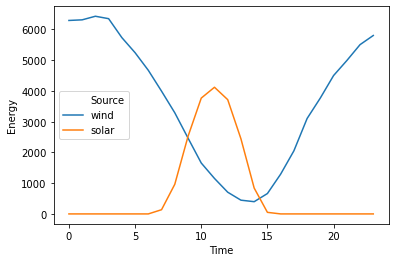

In [206]:
# Start with 01.01.2016
d = "2016-01-01"
edf_day = edf.loc[edf.index.str.startswith(d)]
wdf_day = wdf.loc[wdf.index.str.startswith(d)]

# make dataframe for that day
t = list(range(24))*2
wind = np.array(edf_day.DE_wind_onshore_generation_actual)
solar = np.array(edf_day.DE_solar_generation_actual)
energy = np.concatenate((wind, solar))
energy_type = np.array(['wind']*24 + ['solar']*24)
data = {'Energy': energy, 'Source': energy_type, 'Time': t}
df = pd.DataFrame(data)

sns.lineplot(x='Time', y='Energy', hue='Source', data=df)

In [224]:
# Use remaining data to fit linear model and generate predictions
keep_train = [not x.startswith(d) for x in list(edf.index)]
edf_train = edf.loc[keep_train]
wdf_train = wdf.loc[keep_train]

# Train wind model
wind_model = LinearRegression()
wind_x = wdf_train.copy()
wind_y = np.array(edf_train.copy().DE_wind_onshore_generation_actual)
wind_x = np.array(wind_x.filter(regex='windspeed_10m'))
wind_model.fit(wind_x, wind_y)

# Train solar model
solar_model = LinearRegression()
solar_x = np.array(wdf_train.copy())
solar_y = np.array(edf_train.copy().DE_solar_generation_actual)
solar_model.fit(solar_x, solar_y)

# Now predict for the day 'd'
x_pred_wind = wdf_day.copy()
x_pred_wind = np.array(x_pred_wind.filter(regex='windspeed_10m'))

x_pred_solar = np.array(wdf_day.copy())

pred_wind = wind_model.predict(x_pred_wind)
pred_solar = solar_model.predict(x_pred_solar)

# Set negative values to zero
pred_wind = [x if x > 0 else 0 for x in pred_wind]
pred_solar = [x if x > 0 else 0 for x in pred_solar]


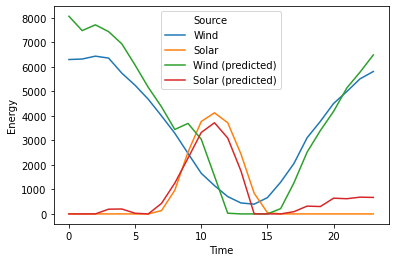

In [276]:
t = list(range(24))*4
wind = np.array(edf_day.DE_wind_onshore_generation_actual)
solar = np.array(edf_day.DE_solar_generation_actual)
energy = np.concatenate((wind, solar, pred_wind, pred_solar))
energy_type = np.array(['Wind']*24 + ['Solar']*24 + ['Wind (predicted)']*24 + ['Solar (predicted)']*24)
data = {'Energy': energy, 'Source': energy_type, 'Time': t}
df = pd.DataFrame(data)

sns.lineplot(x='Time', y='Energy', hue='Source', data=df, markers=True)

In [341]:
green_energy = np.array(pred_wind) + np.array(pred_solar)
green_energy

array([8058.08657107, 7472.77507139, 7707.63309671, 7622.75978419,
       7131.28447243, 6094.832014  , 5156.6541384 , 4792.86111142,
       4697.68082289, 5961.80986596, 6363.17037931, 5258.57153616,
       3123.23220113, 1751.41682721,    0.        ,    0.        ,
        215.66880217, 1352.71303592, 2836.70218022, 3697.7965305 ,
       4821.07896535, 5752.62934254, 6463.49061666, 7151.46518432])

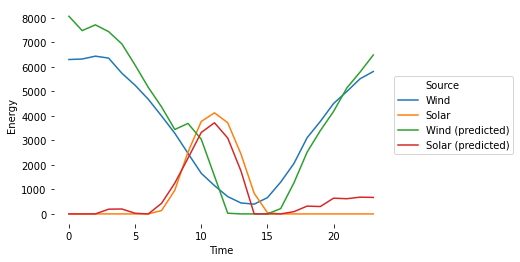

In [277]:
g = sns.lineplot(x='Time', y='Energy', hue='Source', data=df)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
sns.despine(left=True, bottom=True)

# Regional Energy Generation
Extract coefficients from linear model to model regional usage

In [328]:
# Get Hamburg index (DE60)
wind_x = wdf.copy()
wind_x = wind_x.filter(regex='windspeed_10m')
wind_x.drop(['DE_windspeed_10m'], axis=1, inplace=True)
cols = np.array(wind_x.columns)
hamburg_idx = np.where(cols == "DE60_windspeed_10m")[0][0]

wind_y = np.array(edf.copy().DE_wind_onshore_generation_actual)
wind_x = np.array(wind_x)

model = LinearRegression()
model = model.fit(wind_x, wind_y)

coefs = model.coef_
coef_hh = coefs[hamburg_idx]
bias = model.intercept_

In [329]:
model.score(wind_x, wind_y)

0.868615435674749

In [330]:
coefs

array([-1.31134505e+02,  8.81730278e+02, -4.66754420e+02,  1.81577282e+02,
        7.97994839e+02, -4.77088887e+02,  2.89486549e+02, -1.00351803e+03,
        3.13142774e+02,  6.90668902e+02, -5.04945865e+02,  9.12319301e+02,
       -1.15981389e+03, -2.04185207e+03, -2.48629156e+03, -5.28627214e+02,
        6.19473817e+02, -1.11196396e+03,  5.65524564e+02,  6.43342985e+02,
       -9.55301897e+02,  4.38911524e+03,  1.30834415e+03,  1.63891476e+02,
        6.31444184e+01, -5.17873024e+02,  6.73462270e+02,  5.73732433e+02,
       -3.89097389e+02,  1.46928967e+02, -4.98027696e+02,  3.39658040e+02,
        3.05439976e+00,  5.45463268e+02,  9.49035422e+02, -7.78548350e+02,
        3.33494434e+02,  6.58973083e+02])

In [322]:
def predict_windEnergy_regional(windspeed, coef_regional, bias):
    energy = windspeed * coef_regional
    energy = energy + bias
    return energy

In [323]:
wind_x = wdf.copy()
windspeed_hh = np.array(wind_x.filter(regex='DE60_windspeed_10m').DE60_windspeed_10m)

energy_hh = predict_windEnergy_regional(windspeed_hh, coef_hh, bias)

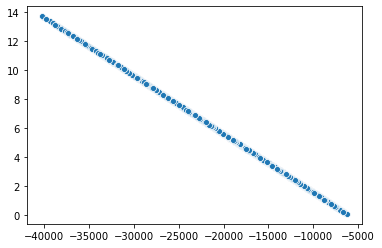

In [324]:
sns.scatterplot(energy_hh, windspeed_hh)

In [279]:
solar_x = wdf.copy()
solar_x = solar_x.filter(regex='radiation_*')
solar_y = np.array(edf.copy().DE_solar_generation_actual)

model = LinearRegression()
model = model.fit(solar_x, solar_y)
model.score(solar_x, solar_y)

0.9198967585955081

In [275]:
model.coef_

array([-4578.63509758, -4581.89551438,   211.45953544,   206.64204588,
         151.94461781,   158.52475666,   113.52086771,   110.25482829,
         100.55057618,   100.49060142,   250.02864948,   248.27822787,
          66.50573125,    73.59132205,    59.76130119,    52.42890916,
          58.14517127,    60.97724555,    91.61596365,    95.41403248,
          74.36774012,    74.79000337,    91.73629036,    97.17108001,
         168.61029938,   172.95695336,   184.71846118,   181.74746453,
          42.42690617,    47.26014908,   109.28803458,   108.87867256,
         209.7367758 ,   218.26588035,    56.08424701,    49.00197446,
          65.97143278,    66.36054182,   100.55577748,    99.85731626,
          94.99495472,    93.60893997,   119.25607665,   126.1107437 ,
          95.45062242,    86.51650996,   138.70352071,   134.23137218,
         292.75461896,   289.32553483,   251.17839567,   248.28553412,
         162.82330033,   156.58535356,   115.34350356,   106.30428032,
      

In [342]:
ts_path = "../opsd-time_series-2019-06-05/time_series_60min_singleindex.csv"
edf = pd.read_csv(ts_path)


In [343]:
edf.DE_load_forecast_entsoe_transparency

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
5             NaN
6             NaN
7             NaN
8             NaN
9             NaN
10            NaN
11            NaN
12            NaN
13            NaN
14            NaN
15            NaN
16            NaN
17            NaN
18            NaN
19            NaN
20            NaN
21            NaN
22            NaN
23            NaN
24            NaN
25            NaN
26            NaN
27            NaN
28            NaN
29            NaN
           ...   
125563    55946.0
125564    54757.0
125565    50966.0
125566    47305.0
125567    44180.0
125568    42371.0
125569    41324.0
125570    41555.0
125571    42218.0
125572    44718.0
125573    49488.0
125574    55001.0
125575    58910.0
125576    60365.0
125577    61402.0
125578    62472.0
125579    61959.0
125580    60723.0
125581    59509.0
125582    58822.0
125583    57873.0
125584    57360.0
125585    57396.0
125586    56704.0
125587    